## MultiClassClassification using PyTorch 

#### Hemant Thapa 

#### 1. Libraries 

In [1]:
import torch
import itertools
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt

In [2]:
from tabulate import tabulate
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score

#### 2. Creating DataSet 

In [3]:
# generate random dataset with 4 classes
X, y = make_classification(
    n_samples=400,
    # total number of features
    n_features=2,  
    # number of informative features
    n_informative=2,  
    # number of redundant features
    n_redundant=0,  
    n_classes=4,
    n_clusters_per_class=1,
    random_state=1
)

In [4]:
# shape of feature and target
X.shape, y.shape

((400, 2), (400,))

In [5]:
X[:10]

array([[ 1.96483605,  1.73695657],
       [ 1.77127137,  1.66217648],
       [ 0.47681872,  0.7975874 ],
       [-1.57678047, -1.7224858 ],
       [-0.72243802, -0.92674432],
       [ 0.28797535,  0.47186696],
       [-0.72358704, -0.55813827],
       [ 1.02442104, -1.15773151],
       [-1.14993489, -0.82763673],
       [-1.32851012,  2.19379939]])

In [6]:
y[:40]

array([3, 3, 3, 0, 0, 0, 0, 2, 0, 1, 0, 0, 3, 1, 2, 3, 0, 1, 3, 0, 0, 2,
       2, 0, 2, 0, 3, 1, 0, 3, 1, 3, 1, 1, 2, 1, 3, 0, 0, 0])

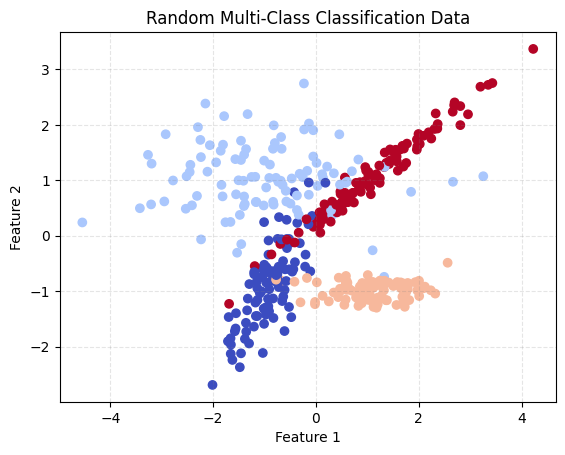

In [7]:
# scatter plot
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, marker='o')
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Random Multi-Class Classification Data")
plt.grid(True, ls='--', alpha=0.2, color='grey')
plt.show()

#### 3. Feature Engineering 

In [8]:
# splitting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
# PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
# torch.long for class labels
y_train_tensor = torch.tensor(y_train, dtype=torch.long)  
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

#### 4. Creating Model for Multi Class Classification 

In [10]:
class MultiClassClassification(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, hidden_activation='relu', output_activation=None):
        super(MultiClassClassification, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.hidden_activation = self.get_activation(hidden_activation)
        self.fc2 = nn.Linear(hidden_size, num_classes)
        self.output_activation = self.get_activation(output_activation)

    def forward(self, x):
        out = self.fc1(x)
        if self.hidden_activation:
            out = self.hidden_activation(out)
        out = self.fc2(out)
        if self.output_activation:
            out = self.output_activation(out)
        return out

    def get_activation(self, activation):
        if activation == 'relu':
            return nn.ReLU()
        elif activation == 'sigmoid':
            return nn.Sigmoid()
        elif activation == 'tanh':
            return nn.Tanh()
        elif activation == 'softmax':
            return nn.Softmax(dim=1)
        elif activation is None:
            return None
        else:
            raise ValueError(f"Activation function '{activation}' is not supported.")

#### 5. Training Model 

In [11]:
input_size = X_train.shape[1]
hidden_size = 64
num_classes = len(set(y_train))
model = MultiClassClassification(input_size, hidden_size, num_classes, hidden_activation='relu', output_activation='softmax')

In [12]:
# cross Entropy Loss
criterion = nn.CrossEntropyLoss()

# learning rate
learning_rate = 0.01

# optimization algorithm
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# total number of epochs
num_epochs = 5000

# lists to store training and test loss
train_loss_values = []
test_loss_values = []
train_accuracy_values = []
test_accuracy_values = []

for epoch in range(num_epochs):
    # forward pass and compute training loss
    outputs = model(X_train_tensor)
    train_loss = criterion(outputs, y_train_tensor.long())  # Ensure y_train_tensor is cast to long
    # backward and optimise
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()

    train_loss_values.append(train_loss.item())
    
    # compute training accuracy
    with torch.no_grad():
        train_logits = model(X_train_tensor)
        train_predictions = torch.argmax(train_logits, axis=1)
        train_accuracy = accuracy_score(y_train_tensor.numpy(), train_predictions.numpy())
        train_accuracy_values.append(train_accuracy)

    # compute test loss
    with torch.no_grad():
        test_outputs = model(X_test_tensor)
        test_loss = criterion(test_outputs, y_test_tensor.long())  
        test_loss_values.append(test_loss.item())
        
        # compute test accuracy
        test_logits = model(X_test_tensor)
        test_predictions = torch.argmax(test_logits, axis=1)
        test_accuracy = accuracy_score(y_test_tensor.numpy(), test_predictions.numpy())
        test_accuracy_values.append(test_accuracy)

    if (epoch+1) % 1000 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_loss.item():.4f}, Test Loss: {test_loss.item():.4f}, Training Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}')


Epoch [1000/5000], Training Loss: 0.9357, Test Loss: 0.9106, Training Accuracy: 0.8812, Test Accuracy: 0.9250
Epoch [2000/5000], Training Loss: 0.8951, Test Loss: 0.8686, Training Accuracy: 0.8938, Test Accuracy: 0.9250
Epoch [3000/5000], Training Loss: 0.8802, Test Loss: 0.8525, Training Accuracy: 0.8938, Test Accuracy: 0.9250
Epoch [4000/5000], Training Loss: 0.8722, Test Loss: 0.8434, Training Accuracy: 0.8906, Test Accuracy: 0.9250
Epoch [5000/5000], Training Loss: 0.8670, Test Loss: 0.8373, Training Accuracy: 0.8938, Test Accuracy: 0.9250


#### 6. Loss Plot 

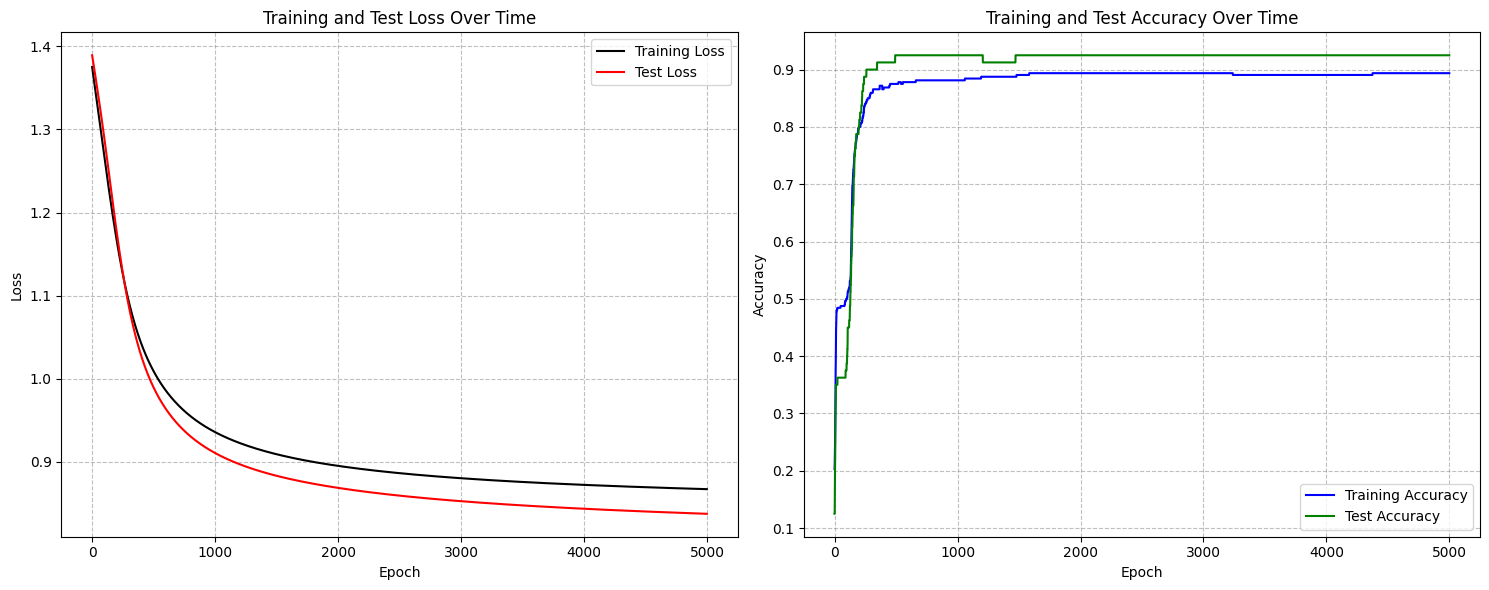

In [13]:
# loss and accuracy plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
# loss plot
ax1.plot(train_loss_values, label='Training Loss', color='black')
ax1.plot(test_loss_values, label='Test Loss', color='red')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Test Loss Over Time')
ax1.grid(True, ls='--', alpha=0.5, color='grey')
ax1.legend()
# accuracy plot
ax2.plot(train_accuracy_values, label='Training Accuracy', color='blue')
ax2.plot(test_accuracy_values, label='Test Accuracy', color='green')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Training and Test Accuracy Over Time')
ax2.grid(True, ls='--', alpha=0.5, color='grey')
ax2.legend()
plt.tight_layout()
plt.show()

#### 7. Model Evaluation 

In [14]:
def classification_evaluation(model, X_train, y_train, X_test, y_test):

    train_logits = model(torch.tensor(X_train, dtype=torch.float32))
    train_predictions = torch.argmax(train_logits, axis=1).numpy()
    test_logits = model(torch.tensor(X_test, dtype=torch.float32))
    test_predictions = torch.argmax(test_logits, axis=1).numpy()

    # evaluation metrics for the train set
    train_accuracy = accuracy_score(y_train, train_predictions)
    train_precision = precision_score(y_train, train_predictions, average='weighted')
    train_recall = recall_score(y_train, train_predictions, average='weighted')
    train_f1 = f1_score(y_train, train_predictions, average='weighted')
    train_conf_matrix = confusion_matrix(y_train, train_predictions)

    # evaluation metrics for the test set
    test_accuracy = accuracy_score(y_test, test_predictions)
    test_precision = precision_score(y_test, test_predictions, average='weighted')
    test_recall = recall_score(y_test, test_predictions, average='weighted')
    test_f1 = f1_score(y_test, test_predictions, average='weighted')

    print("Train Set Evaluation:")
    print(f"Accuracy: {train_accuracy:.4f}")
    print(f"Precision: {train_precision:.4f}")
    print(f"Recall: {train_recall:.4f}")
    print(f"F1-score: {train_f1:.4f}")
    print("\nTest Set Evaluation:")
    print(f"Accuracy: {test_accuracy:.4f}")
    print(f"Precision: {test_precision:.4f}")
    print(f"Recall: {test_recall:.4f}")
    print(f"F1-score: {test_f1:.4f}")


In [15]:
classification_evaluation(model, X_train, y_train, X_test, y_test)

Train Set Evaluation:
Accuracy: 0.8938
Precision: 0.8963
Recall: 0.8938
F1-score: 0.8936

Test Set Evaluation:
Accuracy: 0.9250
Precision: 0.9258
Recall: 0.9250
F1-score: 0.9251


In [16]:
# model evaluation
with torch.no_grad():
    model.eval()
    train_predictions = torch.argmax(model(X_train_tensor), dim=1).numpy()
    test_predictions = torch.argmax(model(X_test_tensor), dim=1).numpy()

In [17]:
print('Train Set Classification Report:')
print(classification_report(y_train, train_predictions))

Train Set Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.90      0.88        80
           1       0.90      0.79      0.84        76
           2       0.99      0.97      0.98        86
           3       0.83      0.91      0.87        78

    accuracy                           0.89       320
   macro avg       0.89      0.89      0.89       320
weighted avg       0.90      0.89      0.89       320



In [18]:
print('\nTest Set Classification Report:')
print(classification_report(y_test, test_predictions))


Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.89      0.87        19
           1       0.96      0.96      0.96        26
           2       0.92      0.85      0.88        13
           3       0.95      0.95      0.95        22

    accuracy                           0.93        80
   macro avg       0.92      0.91      0.92        80
weighted avg       0.93      0.93      0.93        80



#### 8. Decision Boundary Plot 

In [19]:
# decision boundaries with class labels
def decision_boundary_with_labels(model, X, y):
    # set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    # step size in the mesh
    h = 0.02  
    # generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    grid_tensor = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)
    # predict the function value for the whole grid
    with torch.no_grad():
        model.eval()
        Z = torch.argmax(model(grid_tensor), axis=1).numpy()
    Z = Z.reshape(xx.shape)
    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
    # class labels
    unique_classes = np.unique(y)
    for class_label in unique_classes:
        class_indices = np.where(y == class_label)[0]
        plt.scatter(X[class_indices, 0], X[class_indices, 1], label=f'Class {int(class_label)}', marker='o', edgecolors='k')
    plt.legend()
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title('Decision Boundary Plot with Class Labels')
    plt.grid(True, ls='--', alpha=0.2, color='grey')
    plt.show()

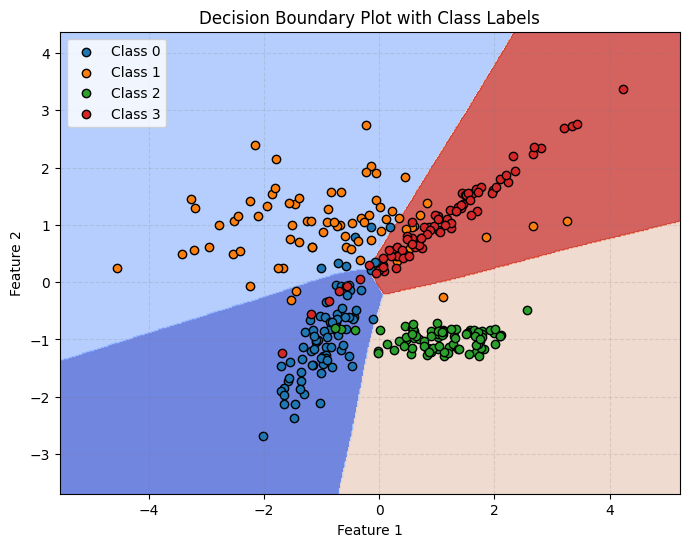

In [20]:
decision_boundary_with_labels(model, X_train, y_train)

#### 9. Confusion Matrix 

In [21]:
# confusion matrix
def conf_matrix(model, X, y):
    # predict labels
    with torch.no_grad():
        model.eval()
        predictions = torch.argmax(model(torch.tensor(X, dtype=torch.float32)), axis=1).numpy()
    
    # confusion matrix
    cm = confusion_matrix(y, predictions)
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    classes = np.unique(y)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    
    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.show()

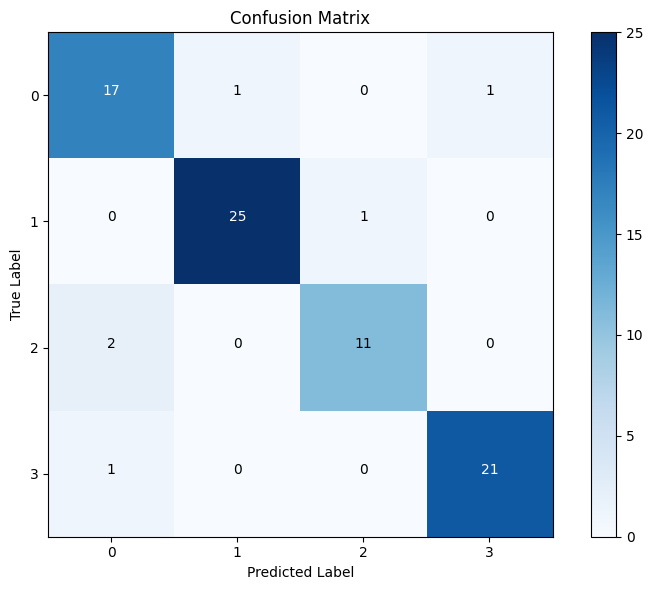

In [22]:
conf_matrix(model, X_test, y_test)

In [23]:
def tp_fp_tn_fn(conf_matrix):
    #TP, FP, TN, FN for each class
    class_tp = {}
    class_fp = {}
    class_tn = {}
    class_fn = {}
    
    num_classes = len(conf_matrix)
    
    for i in range(num_classes):
        tp = conf_matrix[i, i]
        fp = np.sum(conf_matrix[:, i]) - tp
        fn = np.sum(conf_matrix[i, :]) - tp
        tn = np.sum(conf_matrix) - tp - fp - fn
        
        class_tp[i] = tp
        class_fp[i] = fp
        class_tn[i] = tn
        class_fn[i] = fn
    
    return class_tp, class_fp, class_tn, class_fn

In [24]:
predictions = model(torch.tensor(X_test, dtype=torch.float32)).argmax(axis=1).numpy()
predictions[:10]

array([1, 1, 2, 3, 2, 1, 0, 2, 3, 3])

In [25]:
conf_matrix = confusion_matrix(y_test, predictions)
class_tp, class_fp, class_tn, class_fn = tp_fp_tn_fn(conf_matrix)

In [26]:
table_data = []
for class_label in range(len(class_tp)):
    table_data.append([class_label, class_tp[class_label], class_fp[class_label], class_tn[class_label], class_fn[class_label]])

headers = ["Class", "True Positives", "False Positives", "True Negatives", "False Negatives"]
print(tabulate(table_data, headers=headers, tablefmt="grid"))

+---------+------------------+-------------------+------------------+-------------------+
|   Class |   True Positives |   False Positives |   True Negatives |   False Negatives |
+=========+==================+===================+==================+===================+
|       0 |               17 |                 3 |               58 |                 2 |
+---------+------------------+-------------------+------------------+-------------------+
|       1 |               25 |                 1 |               53 |                 1 |
+---------+------------------+-------------------+------------------+-------------------+
|       2 |               11 |                 1 |               66 |                 2 |
+---------+------------------+-------------------+------------------+-------------------+
|       3 |               21 |                 1 |               57 |                 1 |
+---------+------------------+-------------------+------------------+-------------------+


#### 10. ROC Curve

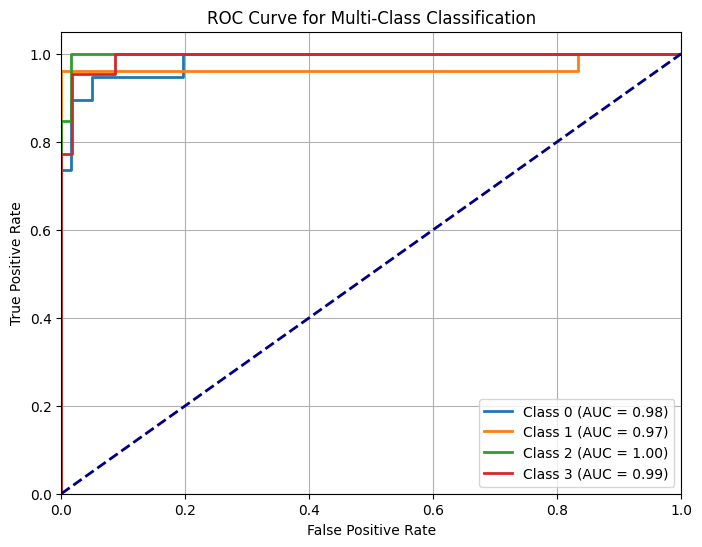

In [27]:
# probabilities for each class 
probs = model(torch.tensor(X_test, dtype=torch.float32)).detach().numpy()

# ROC curve for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test == i, probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# ROC curve for each class
plt.figure(figsize=(8, 6))

for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-Class Classification')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [28]:
# predictions for the test set
with torch.no_grad():
    model.eval()
    logits = model(torch.tensor(X_test, dtype=torch.float32))
    predictions = torch.argmax(logits, axis=1).numpy()

data = []
for i in range(20):
    data.append([f"Sample {i+1}", y_test[i], predictions[i]])

print(tabulate(data, headers=["Sample", "True Value", "Predicted Value"], tablefmt="grid"))

+-----------+--------------+-------------------+
| Sample    |   True Value |   Predicted Value |
+===========+==============+===================+
| Sample 1  |            1 |                 1 |
+-----------+--------------+-------------------+
| Sample 2  |            1 |                 1 |
+-----------+--------------+-------------------+
| Sample 3  |            1 |                 2 |
+-----------+--------------+-------------------+
| Sample 4  |            3 |                 3 |
+-----------+--------------+-------------------+
| Sample 5  |            2 |                 2 |
+-----------+--------------+-------------------+
| Sample 6  |            1 |                 1 |
+-----------+--------------+-------------------+
| Sample 7  |            0 |                 0 |
+-----------+--------------+-------------------+
| Sample 8  |            2 |                 2 |
+-----------+--------------+-------------------+
| Sample 9  |            3 |                 3 |
+-----------+-------

#### References: 

[scikit-learn classification_report](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html)

[scikit-yb classification_report](https://www.scikit-yb.org/en/latest/api/classifier/classification_report.html)
